<a href="https://colab.research.google.com/github/EdisonVazquezG/DeepLearning_Bourbaki/blob/main/Node2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de nodos con Node2Vec

# Introducción
Este notebook mostrará la implementación de una canalización que resuelve problemas de clasificación mediante grafos. El algoritmo fundamental de la solución es Node2Vec.

#### ¿Qué es Node2Vec?
Un problema importante al trabajar con redes es la transformación de la estructura de la red en una representación numérica que pueda transferirse a algoritmos tradicionales de aprendizaje automático. Node2Vec es un algoritmo que permite al usuario mapear nodos de un grafo G a un espacio de embeddings. Generalmente, el espacio de embeddings tiene dimensiones menores que el número de nodos del grafo original G. El algoritmo intenta preservar la estructura inicial dentro del grafo original. En esencia, los nodos similares dentro del grafo generarán incrustaciones similares en el espacio de embeddings. Estos espacios de embeddings son, en esencia, un vector que corresponde a cada nodo de la red. Los embeddings de grafos se utilizan comúnmente como características de entrada para resolver problemas de aprendizaje automático orientados a la predicción de enlaces, la detección de comunidades, la clasificación, etc.

#### ¿Qué es la clasificación de nodos?
La clasificación de nodos es una aplicación común del aprendizaje automático en grafos. Generalmente, se entrena un modelo de clasificación para aprender a qué clase pertenece un nodo. Este enfoque es común tanto para la clasificación binaria como para la multiclase. En la clasificación binaria se trabaja con dos clases diferentes, mientras que en la multiclase se trabaja con más de dos. En este notebook, utilizaremos node2vec para generar embeddings de nodos en la red. Node2vec está diseñado para preservar la estructura inicial dentro del grafo original.

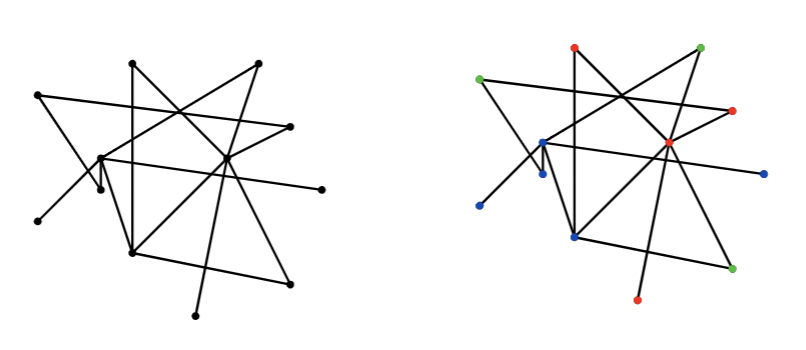


#### Planteamiento del problema
Dado el tema principal de los artículos de investigación publicados en arXiv, crearemos un pipeline que entrenará un modelo para clasificar un artículo de investigación según su tema principal.

#### Arquitectura de la solución
Comenzaremos creando una red con nodos como artículos y aristas que conectan estos nodos según el tema principal que conecta un par de artículos. Tras crear esta red, utilizaremos node2vec para generar embeddings de nodos asociadas a cada artículo. Finalmente, podemos mapear los embeddings de nodos asociadas a cada nodo con su tema asociado. Los embeddings se pueden transmitir como características y el tema principal como objetivo para entrenar un modelo de clasificación.

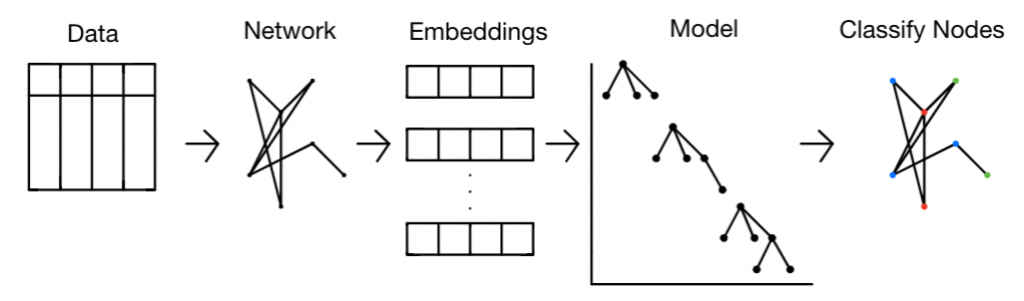

### ¿Cómo funciona? Word2Vec
* Random Walks:

Node2Vec realiza caminatas aleatorias sobre el grafo, como si estuviera explorando los vecinos de cada nodo.
Estas caminatas generan secuencias de nodos, similares a frases en lenguaje natural.

* Word2Vec:

Luego, esas secuencias se tratan como texto y se entrenan con Word2Vec, un modelo de red neuronal simple que aprende representaciones de palabras (en este caso, nodos).
Así, nodos que aparecen en contextos similares tendrán vectores similares.
Parámetros clave:

* p y q: controlan el sesgo de las caminatas (exploración local vs global).
* dimensions: número de dimensiones del embedding.
* window, min_count, batch_words: parámetros del entrenamiento tipo Word2Vec.

 Parámetros de Node2Vec
1. p (Return parameter)
Controla la probabilidad de volver al nodo anterior durante la caminata.
* Valor alto: menos probabilidad de regresar → fomenta exploración.
* Valor bajo: más probabilidad de regresar → fomenta profundidad local.
2. q (In-out parameter)
Controla la probabilidad de explorar nodos nuevos.
* Valor alto: caminata más amplia (explora nodos lejanos).
* Valor bajo: caminata más profunda (explora vecinos cercanos).
En conjunto, p y q permiten balancear entre BFS (exploración local) y DFS (exploración global).

Parámetros del entrenamiento tipo Word2Vec

3. window

Tamaño del contexto alrededor de cada nodo en las secuencias.
Ejemplo: si window=2, el modelo aprende a predecir nodos que están a 2 pasos de distancia en la caminata.

4. min_count

Frecuencia mínima para que un nodo sea incluido en el entrenamiento.
Si un nodo aparece menos veces que min_count, se descarta.

5. batch_words

Número de nodos procesados por lote durante el entrenamiento.
Afecta el rendimiento y uso de memoria.

#### Datos
Utilizaremos la API de arXiv para recopilar datos sobre artículos de investigación y publicaciones asociadas con diversas palabras clave. Según las condiciones de uso de la API de arXiv, su uso es completamente gratuito y se recomienda. Para obtener más información sobre sus condiciones de uso, consulte su documentación, que puede encontrar https://info.arxiv.org/help/api/user-manual

En este notebook, mostraré cómo utilizar la API a través de Python para recopilar la siguiente información necesaria para el modelo que estamos construyendo hoy. Si desea utilizar esta API a través de otros lenguajes de programación o simplemente desea más información sobre cómo usarla, le recomiendo encarecidamente que consulte su documentación, que puede encontrar en el link anterior.

Utilizaremos la API de arXiv para recopilar información sobre los últimos artículos de investigación basados ​​en las consultas que hemos identificado anteriormente. Esto nos permitirá crear una red a partir de los datos de estos artículos de investigación y, posteriormente, intentar clasificar los nodos de esa red. Para este artículo, buscaré un máximo de 250 resultados por consulta, pero no es necesario que se ajuste a las mismas restricciones. La API de arXiv permite a los usuarios acceder a hasta 300.000 resultados por consulta. La función descrita a continuación generará un archivo CSV con la siguiente información: título, fecha, ID del artículo, URL, tema principal, todos los temas, autores y año. Se puede obtener más información, como enlaces, resumen y artículo, pero decidí no hacerlo, ya que estas funciones no se utilizarán realmente para este análisis y tutorial.


### Paqueterias

In [ ]:
!pip install pyvis

In [1]:
!pip install arxiv

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 8.9 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=a08a2ed946218b709e23961ba62a68cf4084254a216bffab00cdbf6a09759b3d
  Stored in directory: /root/.cache/pip/wheels/03/f5/1a/23761066dac1d0e8e683e5fdb27e12de53209d05a4a37e6246
Successfully built sgmllib3k


In [2]:
!pip install Node2Vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 11.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.1 requires scipy>=1.14.0;

In [3]:
!pip install --upgrade arxiv

In [27]:
import networkx as nx
import pandas as pd
import numpy as np
import arxiv

from arxiv import Client, SortCriterion
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, classification_report
from node2vec import Node2Vec as n2v

In [2]:
from logging import error


# Lista de consultas
queries = ['automl', 'machinelearning', 'data', 'physics', 'mathematics', 'recommendation system', 'nlp', 'neural networks']

def search_arxiv(queries, max_results=100):
    """
    Search arXiv for a list of queries and return a DataFrame with metadata.

    Parameters:
        queries (List[str]): Keywords to search on arXiv.
        max_results (int): Max number of results per query (default: 100).

    Returns:
        pd.DataFrame: DataFrame with columns: title, date, article_id, url, main_topic, all_topics, authors, year.
    """
    client = Client()
    records = []

    for query in queries:
        try:
            search = arxiv.Search(
                query=query,
                max_results=max_results,
                sort_by=SortCriterion.SubmittedDate,
                sort_order=arxiv.SortOrder.Descending
            )
            results = client.results(search)
            for res in results:
                records.append({
                    'title': res.title,
                    'date': res.published,
                    'article_id': res.entry_id,
                    'url': res.pdf_url,
                    'main_topic': res.primary_category,
                    'all_topics': res.categories,
                    'authors': [author.name for author in res.authors]
                })
        except Exception as e:
            print(f"❌ Error with query '{query}': {e}")

    df = pd.DataFrame(records)
    if not df.empty:
        df['year'] = pd.DatetimeIndex(df['date']).year
        unique_ids = df.article_id.unique()
        id_map = {art: idx for idx, art in enumerate(unique_ids)}
        df['article_id'] = df['article_id'].map(id_map)
    return df

# Ejecutar búsqueda
research_df = search_arxiv(queries=queries, max_results=250)
print(f"🔍 Total papers found: {research_df.shape[0]}")

❌ Error with query 'physics': Page of results was unexpectedly empty (https://export.arxiv.org/api/query?search_query=physics&id_list=&sortBy=submittedDate&sortOrder=descending&start=200&max_results=100)
❌ Error with query 'recommendation system': Page of results was unexpectedly empty (https://export.arxiv.org/api/query?search_query=recommendation+system&id_list=&sortBy=submittedDate&sortOrder=descending&start=200&max_results=100)
❌ Error with query 'neural networks': Page of results was unexpectedly empty (https://export.arxiv.org/api/query?search_query=neural+networks&id_list=&sortBy=submittedDate&sortOrder=descending&start=100&max_results=100)
🔍 Total papers found: 1522


A continuación, se muestra un ejemplo del resultado que obtuve al acceder a la API de arXiv. El resultado podría variar según las palabras clave y el horario de consulta o que no alcanza el límite del topic

In [3]:
research_df.columns

Index(['title', 'date', 'article_id', 'url', 'main_topic', 'all_topics',
       'authors', 'year'],
      dtype='object')

In [26]:
research_df

,title,date,article_id,url,main_topic,all_topics,authors,year
0,Surrogate Benchmarks for Model Merging Optimiz...,2025-09-02 17:51:03+00:00,0,http://arxiv.org/pdf/2509.02555v1,cs.LG,"[cs.LG, cs.AI, cs.NE]","[Rio Akizuki, Yuya Kudo, Nozomu Yoshinari, Yoi...",2025
1,Graph-Based Feature Augmentation for Predictiv...,2025-08-28 16:44:04+00:00,1,http://arxiv.org/pdf/2508.20986v1,cs.DB,"[cs.DB, cs.LG]","[Lianpeng Qiao, Ziqi Cao, Kaiyu Feng, Ye Yuan,...",2025
2,"Khiops: An End-to-End, Frugal AutoML and XAI M...",2025-08-28 08:00:48+00:00,2,http://arxiv.org/pdf/2508.20519v1,cs.LG,[cs.LG],"[Marc Boullé, Nicolas Voisine, Bruno Guerraz, ...",2025
3,"Tune My Adam, Please!",2025-08-27 09:57:45+00:00,3,http://arxiv.org/pdf/2508.19733v2,cs.LG,[cs.LG],"[Theodoros Athanasiadis, Steven Adriaensen, Sa...",2025
4,Quickly Tuning Foundation Models for Image Seg...,2025-08-24 10:06:02+00:00,4,http://arxiv.org/pdf/2508.17283v1,cs.CV,"[cs.CV, cs.LG]","[Breenda Das, Lennart Purucker, Timur Carstens...",2025
...,...,...,...,...,...,...,...,...
1517,Toward Faithfulness-guided Ensemble Interpreta...,2025-09-04 18:09:17+00:00,1277,http://arxiv.org/pdf/2509.04588v1,cs.LG,"[cs.LG, cs.AI]","[Siyu Zhang, Kenneth Mcmillan]",2025
1518,Communication-Efficient Collaborative LLM Infe...,2025-09-04 18:01:32+00:00,1278,http://arxiv.org/pdf/2509.04576v1,eess.SP,[eess.SP],"[Ce Zheng, Tingting Yang]",2025
1519,ChronoGraph: A Real-World Graph-Based Multivar...,2025-09-04 17:59:52+00:00,1279,http://arxiv.org/pdf/2509.04449v1,cs.LG,"[cs.LG, cs.AI]","[Adrian Catalin Lutu, Ioana Pintilie, Elena Bu...",2025
1520,From Lines to Shapes: Geometric-Constrained Se...,2025-09-04 17:53:45+00:00,1280,http://arxiv.org/pdf/2509.04437v1,cs.CV,"[cs.CV, physics.med-ph]","[Benjamin El-Zein, Dominik Eckert, Andreas Fie...",2025


### Crear red
Ahora que obtuvimos los datos mediante la API de arXiv, podemos generar una red. La red tendrá la siguiente estructura: los nodos serán los identificadores de artículo (article_ids) y las aristas serán todos los temas que conectan un par de artículos. Por ejemplo, el identificador de artículo 1 con los temas astrofísica y estadísticas se puede conectar con el identificador de artículo 10 con el tema estadísticas y el identificador de artículo 7 con los temas astrofísica y matemáticas. Esta será una red multiarista donde cada arista tendrá un peso de 1.

In [5]:
def generate_network(df, node_col, edge_col):
    '''
    This function will generate a article to article network given an input DataFrame.
    It will do so by creating an edge_dictionary where each key is going to be a node
    referenced by unique values in node_col and the values will be a list of other nodes
    connected to the key through the edge_col.

    params:
        df (DataFrame) : The dataset which holds the node and edge columns
        node_col (String) : The column name associated to the nodes of the network
        edge_col (String) : The column name associated to the edges of the network

    returns:
        A networkx graph corresponding to the input dataset

    example:
        generate_network(
            research_df,
            node_col = 'article_id',
            edge_col = 'main_topic'
        )
    '''
    edge_dct = {}
    for i,g in df.groupby(node_col):
        topics = g[edge_col].unique()
        edge_df = df[(df[node_col] != i) & (df[edge_col].isin(topics))]
        edges = list(edge_df[node_col].unique())
        edge_dct[i] = edges

    # create nx network
    g = nx.Graph(edge_dct, create_using = nx.MultiGraph)
    return g

tp_nx = generate_network(
    research_df,
    node_col = 'article_id',
    edge_col = 'main_topic'
)



In [6]:

def graph_info(G):
    info = f"Type: {type(G).__name__}\n"
    info += f"Number of nodes: {G.number_of_nodes()}\n"
    info += f"Number of edges: {G.number_of_edges()}\n"
    info += f"Is directed: {G.is_directed()}\n"
    return info

print(graph_info(tp_nx))



Type: Graph
Number of nodes: 1282
Number of edges: 57189
Is directed: False



### Aplicar Node2Vec
Este componente abarcará la ejecución de node2vec en la red generado anteriormente y la creación de los embeddings de nodos asociadas para esa red. Estos embeddings serán cruciales en el futuro, ya que son las principales características necesarias para construir un modelo de clasificación de nodos.

* dimensions: el nodo será representado por un embedding de 16 dimensiones

Se entrena el modelo usando parámetros similares a los de Word2Vec:
* window: tamaño del contexto.
* min_count: frecuencia mínima para incluir un nodo.
* batch_words: tamaño del lote de entrenamiento.

Se extraen los vectores de cada nodo y se construye un DataFrame donde:
* Las filas son nodos (artículos).
* Las columnas son las dimensiones del embedding.

Se une el DataFrame de embeddings con el DataFrame de artículos (research_df) usando el article_id como índice. Esto permite asociar cada vector con su tema principal (main_topic).

In [7]:
g_emb = n2v(tp_nx, dimensions=16)

WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

mdl = g_emb.fit(
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

emb_df = (
    pd.DataFrame(
        [mdl.wv.get_vector(str(n)) for n in tp_nx.nodes()],
        index = tp_nx.nodes
    )
)

emb_df = emb_df.merge(
    research_df[['article_id', 'main_topic']].set_index('article_id'),
    left_index = True,
    right_index = True
)

# Se imprime la frecuencia de los 10 tópicos más comunes en los artículos representados en el grafo.
print(emb_df.main_topic.value_counts().head(10))

Computing transition probabilities:   0%|          | 0/1282 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


main_topic
cs.LG       249
cs.CL       217
quant-ph     91
cs.CV        75
cs.AI        41
math.AP      32
hep-th       29
math-ph      25
gr-qc        25
cs.CR        25
Name: count, dtype: int64


In [8]:
emb_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,main_topic
0,-0.480913,-1.104707,0.219356,0.520513,-0.443774,-0.215192,0.134600,-0.539244,-0.902329,-0.808193,-0.463513,0.546918,-0.333378,0.038943,0.811447,1.466305,cs.LG
1,0.624578,-0.499539,0.418631,1.611409,0.833788,-2.425162,-0.792438,1.056249,-1.333995,-0.843304,0.348624,-2.385888,-0.295590,0.548037,1.263845,1.654251,cs.DB
2,-0.486260,-1.109019,0.175188,0.492347,-0.404689,-0.238216,0.085147,-0.544326,-0.908283,-0.804722,-0.501802,0.615206,-0.283381,0.034527,0.826522,1.476666,cs.LG
3,-0.474667,-1.095348,0.279597,0.572042,-0.421976,-0.134660,0.120842,-0.522069,-0.992991,-0.838761,-0.475932,0.568360,-0.314223,0.094147,0.829954,1.445316,cs.LG
4,-0.231007,-2.073622,0.316883,0.824056,0.243297,-0.948229,-1.547642,-0.076412,-0.812271,0.662910,1.297309,0.145979,1.606562,0.363945,0.161107,1.137623,cs.CV


### ¿Qué puedes hacer con esto?
* Visualizar clusters de artículos por tema.
* Entrenar modelos de clasificación usando los embeddings.
* Explorar similitudes entre artículos en el espacio vectorial.

### Entrenar un clasificador

In [9]:
ft_cols = emb_df.drop(columns = ['main_topic']).columns.tolist()
target_col = 'main_topic'

# train test split
x = emb_df[ft_cols].values
y = emb_df[target_col].values

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size = 0.3
)

# GBC classifier
clf = GradientBoostingClassifier()

# train the model
clf.fit(x_train, y_train)

GradientBoostingClassifier()

### Evaluar el clasificador
Para evaluar el rendimiento de este modelo, analizaremos los siguientes índices de precisión:

* Índice de precisión
* Coeficiente de correlación de Matthew
* Informe de clasificación
* Matriz de confusión

In [10]:
def clf_eval(clf, x_test, y_test):
    '''
    This function will evaluate a sk-learn multi-class classification model based on its
    x_test and y_test values

    params:
        clf (Model) : The model you wish to evaluate the performance of
        x_test (Array) : Result of the train test split
        y_test (Array) : Result of the train test split

    returns:
        This function will return the following evaluation metrics:
            - Accuracy Score
            - Matthews Correlation Coefficient
            - Classification Report
            - Confusion Matrix

    example:
        clf_eval(
            clf,
            x_test,
            y_test
        )
    '''
    y_pred = clf.predict(x_test)
    y_true = y_test

    y_pred = clf.predict(x_test)
    test_acc = accuracy_score(y_test, y_pred)
    print("Testing Accuracy : ", test_acc)

    print("MCC Score : ", matthews_corrcoef(y_true, y_pred))

    print("Classification Report : ")
    print(classification_report(y_test, clf.predict(x_test)))

    print(confusion_matrix(y_pred,y_test))

clf_eval(
    clf,
    x_test,
    y_test
)

Testing Accuracy :  0.925601750547046
MCC Score :  0.9210809646598256
Classification Report : 
                    precision    recall  f1-score   support

       astro-ph.CO       1.00      0.67      0.80         3
       astro-ph.EP       1.00      1.00      1.00         3
       astro-ph.GA       1.00      1.00      1.00         2
       astro-ph.HE       0.75      1.00      0.86         6
       astro-ph.IM       1.00      0.50      0.67         4
       astro-ph.SR       1.00      0.83      0.91         6
   cond-mat.dis-nn       1.00      1.00      1.00         2
 cond-mat.mes-hall       1.00      1.00      1.00         2
 cond-mat.mtrl-sci       1.00      1.00      1.00         5
    cond-mat.other       0.50      1.00      0.67         1
cond-mat.quant-gas       1.00      1.00      1.00         2
     cond-mat.soft       1.00      1.00      1.00         1
cond-mat.stat-mech       1.00      1.00      1.00         3
   cond-mat.str-el       0.50      1.00      0.67         4
    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

### Predecir clases de nodos

In [11]:
pred_ft = [mdl.wv.get_vector(str('21'))] ## el embedding del nodo 21
clf.predict(pred_ft)[0]

'cs.LG'

In [12]:
research_df[research_df['article_id'] == 21]

,title,date,article_id,url,main_topic,all_topics,authors,year
21,Beyond the Single-Best Model: Rashomon Partial...,2025-07-19 20:30:52+00:00,21,http://arxiv.org/pdf/2507.14744v1,cs.LG,[cs.LG],"[Mustafa Cavus, Jan N. van Rijn, Przemysław Bi...",2025


In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# --- 1) Preparación de datos ---
# emb_df: DataFrame de embeddings (index = nodos), con columna 'main_topic' después del merge
# Asegura columnas de features
ft_cols = [c for c in emb_df.columns if c != 'main_topic']

# Solo nodos que tienen etiqueta para entrenar
labeled = emb_df.dropna(subset=['main_topic']).copy()

X = labeled[ft_cols].values
y = labeled['main_topic'].values

# Split reproducible y estratificado (siempre que haya >=2 por clase)
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

# --- 2) Entrenamiento ---
clf = GradientBoostingClassifier(random_state=42)
clf.fit(x_train, y_train)

print(classification_report(y_test, clf.predict(x_test)))

# --- 3) Predicción para TODOS los nodos del grafo ---
emb_df['pred_topic'] = clf.predict(emb_df[ft_cols].values)

# Confianza (probabilidad máxima) para escalar tamaño
proba = clf.predict_proba(emb_df[ft_cols].values)
emb_df['pred_conf'] = proba.max(axis=1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

                    precision    recall  f1-score   support

       astro-ph.CO       0.67      1.00      0.80         2
       astro-ph.EP       1.00      1.00      1.00         2
       astro-ph.GA       1.00      1.00      1.00         3
       astro-ph.HE       0.83      1.00      0.91         5
       astro-ph.IM       1.00      0.33      0.50         3
       astro-ph.SR       1.00      1.00      1.00         5
   cond-mat.dis-nn       1.00      1.00      1.00         3
 cond-mat.mes-hall       1.00      1.00      1.00         3
 cond-mat.mtrl-sci       1.00      1.00      1.00         9
cond-mat.quant-gas       0.50      1.00      0.67         1
     cond-mat.soft       1.00      1.00      1.00         2
cond-mat.stat-mech       1.00      1.00      1.00         1
   cond-mat.str-el       1.00      1.00      1.00         5
 cond-mat.supr-con       0.00      0.00      0.00         0
             cs.AI       1.00      1.00      1.00        12
             cs.CC       1.00      0.50

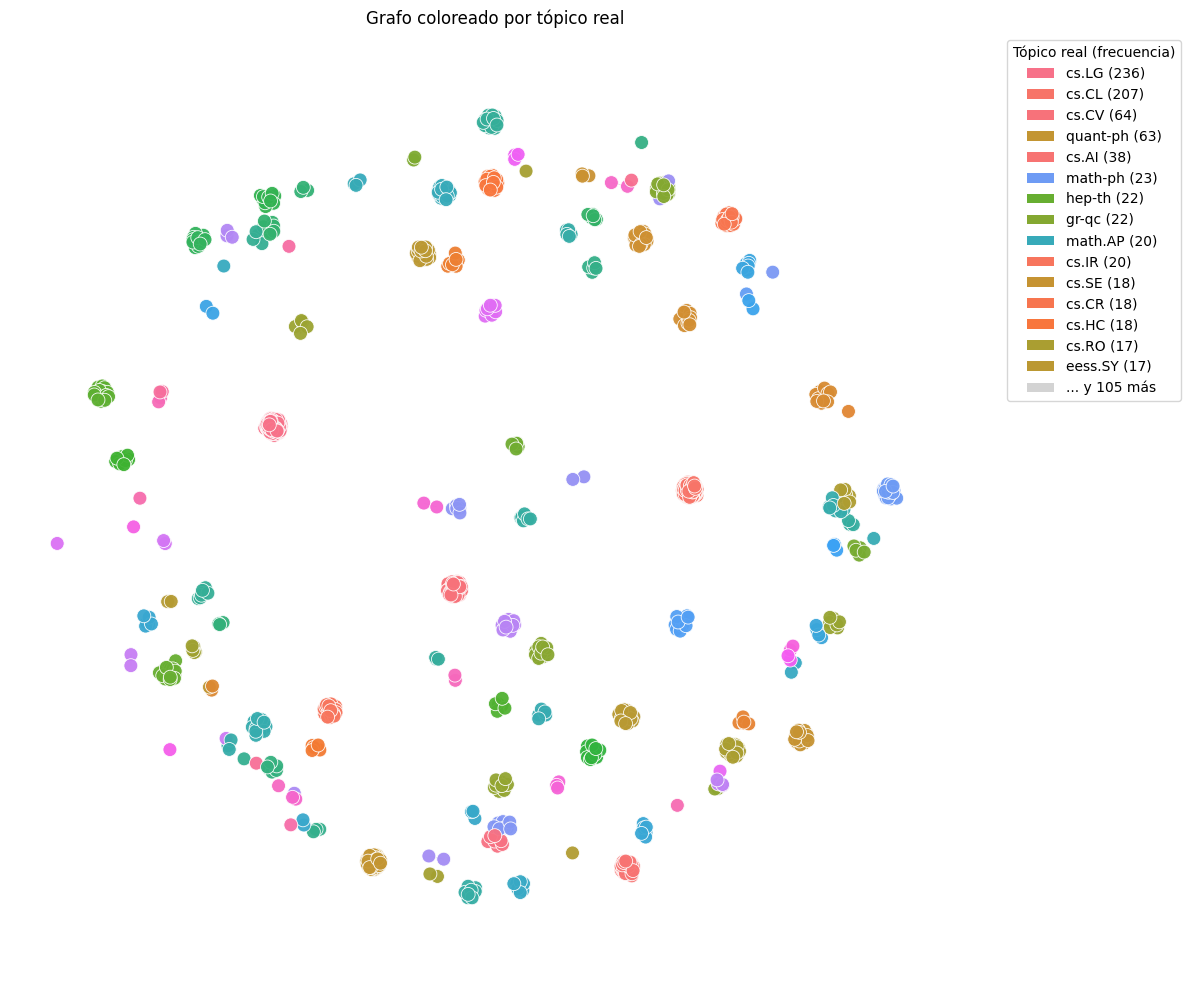

In [24]:
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import pandas as pd
from matplotlib.patches import Patch

# Asegura que tp_nx y emb_df estén definidos

# 1) Alinea nodos del grafo con índices de emb_df
nodelist = [n for n in tp_nx.nodes() if n in emb_df.index]

# 2) Paleta de colores por tópico real
topics = pd.Series(emb_df.loc[nodelist, 'main_topic']).astype(str).unique()
palette = sns.color_palette("tab20", n_colors=len(topics)) if len(topics) <= 20 else sns.color_palette("husl", n_colors=len(topics))
color_map = dict(zip(topics, palette))

# Colores de nodos según tópico real
node_colors = emb_df.loc[nodelist, 'main_topic'].astype(str).map(color_map).tolist()

# 3) Layout y dibujo
G_sub = tp_nx.subgraph(nodelist)
pos = nx.spring_layout(G_sub, seed=42)

plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(G_sub, pos, alpha=0.15, width=0.5)
nx.draw_networkx_nodes(
    G_sub, pos,
    nodelist=nodelist,
    node_color=node_colors,
    node_size=100,
    linewidths=0.6,
    edgecolors='white',
    alpha=0.95
)

# 4) Leyenda
topk_legend = 15
freq = emb_df.loc[nodelist, 'main_topic'].astype(str).value_counts()
top_topics = freq.head(topk_legend).index.tolist()
handles = [Patch(facecolor=color_map[t], label=f"{t} ({freq[t]})") for t in top_topics]
if len(freq) > topk_legend:
    handles.append(Patch(facecolor='lightgrey', label=f"... y {len(freq)-topk_legend} más"))
plt.legend(handles=handles, title='Tópico real (frecuencia)', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.title("Grafo coloreado por tópico real")
plt.axis('off')
plt.tight_layout()
plt.show()


⚠️ El índice de emb_df tiene duplicados. Agregando por nodo...


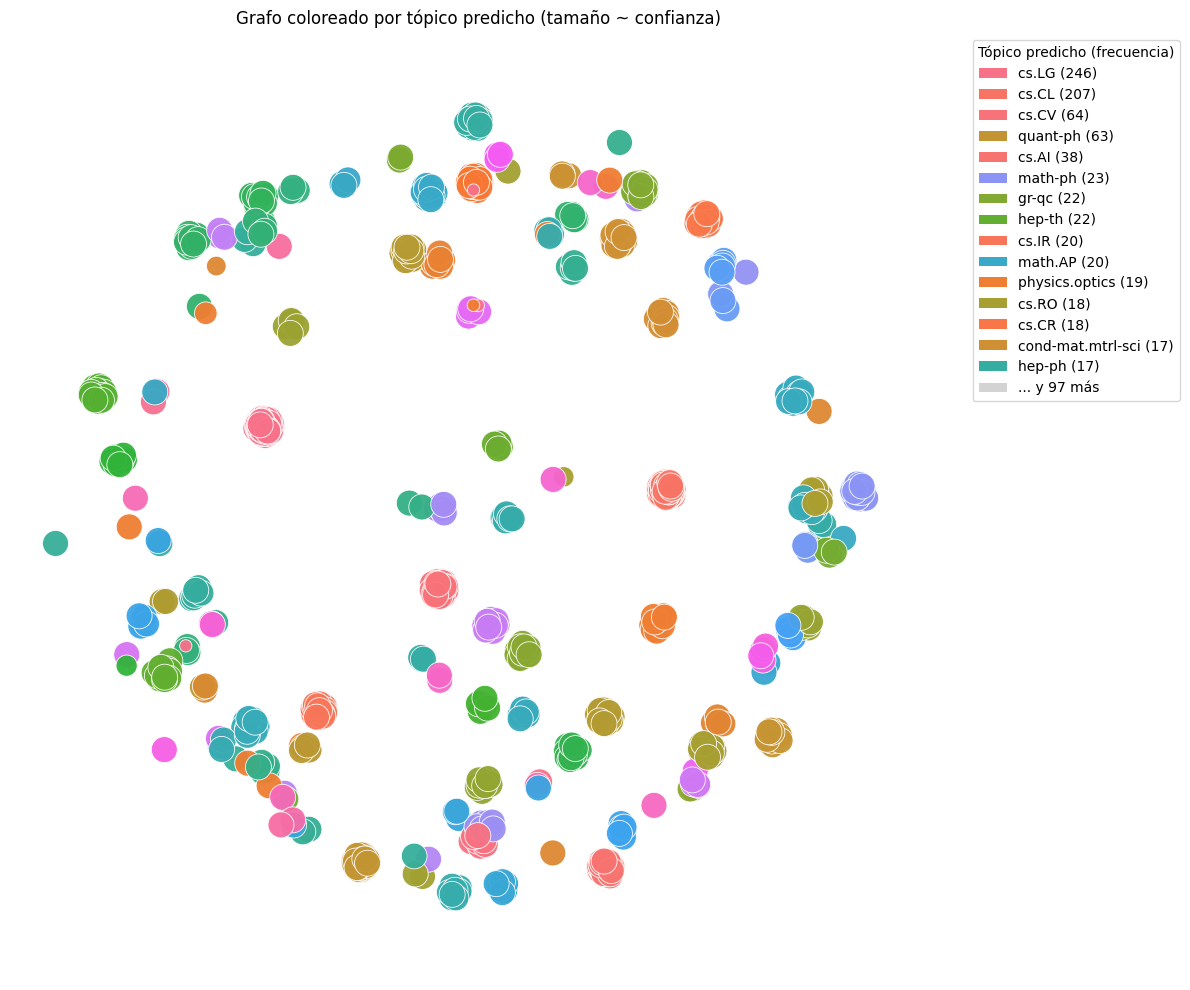

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Patch

# ---------- 0) (Opcional) Garantiza índice único en emb_df ----------
if not emb_df.index.is_unique:
    print("⚠️ El índice de emb_df tiene duplicados. Agregando por nodo...")
    # Agrega promedios para embeddings y conserva la etiqueta más frecuente
    feat_cols = [c for c in emb_df.columns if c not in ['main_topic','pred_topic','pred_conf']]
    emb_df = (
        emb_df.groupby(level=0)
              .agg({**{c: 'mean' for c in feat_cols},
                    'main_topic': (lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]),
                    # si ya existen predicciones, mantén la más confiable
                    **({'pred_topic': (lambda s: s.iloc[0])} if 'pred_topic' in emb_df.columns else {}),
                    **({'pred_conf':  (lambda s: s.max())} if 'pred_conf'  in emb_df.columns else {}),
                   })
    )

# ---------- 1) Alinea nodos del grafo con índices de emb_df ----------
# Solo grafica los nodos para los que tienes predicción
nodelist = [n for n in tp_nx.nodes() if n in emb_df.index]

if len(nodelist) == 0:
    raise ValueError("No hay intersección entre nodos del grafo y el índice de emb_df.")

missing = len(tp_nx) - len(nodelist)
if missing > 0:
    print(f"ℹ️ {missing} nodos del grafo no están en emb_df (no se dibujarán).")

# ---------- 2) Asegura columnas de predicción ----------
if 'pred_topic' not in emb_df.columns or 'pred_conf' not in emb_df.columns:
    raise ValueError("Faltan columnas 'pred_topic' y/o 'pred_conf' en emb_df. Ejecútalas antes de graficar.")

# ---------- 3) Paleta de colores por tópico ----------
topics = pd.Series(emb_df.loc[nodelist, 'pred_topic']).astype(str).unique()
if len(topics) <= 20:
    palette = sns.color_palette("tab20", n_colors=len(topics))
else:
    # 'husl' separa mejor cuando hay muchas clases
    palette = sns.color_palette("husl", n_colors=len(topics))
color_map = dict(zip(topics, palette))

# Colores y tamaños (vectorizado y ordenado por nodelist)
node_colors = emb_df.loc[nodelist, 'pred_topic'].astype(str).map(color_map).tolist()
node_sizes  = (50 + 300*emb_df.loc[nodelist, 'pred_conf'].clip(0, 1)).tolist()  # 50-350

# ---------- 4) Layout y dibujo ----------
# Usa el subgrafo para el layout (más rápido en grafos grandes)
G_sub = tp_nx.subgraph(nodelist)
pos = nx.spring_layout(G_sub, seed=42)  # o nx.kamada_kawai_layout(G_sub)

plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(G_sub, pos, alpha=0.15, width=0.5)

nx.draw_networkx_nodes(
    G_sub, pos,
    nodelist=nodelist,
    node_color=node_colors,
    node_size=node_sizes,
    linewidths=0.6,
    edgecolors='white',
    alpha=0.95
)

# ---------- 5) Leyenda (top-k por frecuencia para que no sea gigante) ----------
topk_legend = 15
freq = emb_df.loc[nodelist, 'pred_topic'].astype(str).value_counts()
top_topics = freq.head(topk_legend).index.tolist()
handles = [Patch(facecolor=color_map[t], label=f"{t} ({freq[t]})") for t in top_topics]
if len(freq) > topk_legend:
    handles.append(Patch(facecolor='lightgrey', label=f"... y {len(freq)-topk_legend} más"))
plt.legend(handles=handles, title='Tópico predicho (frecuencia)', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.title("Grafo coloreado por tópico predicho (tamaño ~ confianza)")
plt.axis('off')
plt.tight_layout()
plt.show()
